In [1]:
!git clone https://github.com/niazwazir/Deep-Image-Prior.git

Cloning into 'Deep-Image-Prior'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 18 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (18/18), done.


In [2]:
!ls

Deep-Image-Prior  sample_data


In [3]:
cd Deep-Image-Prior/

/content/Deep-Image-Prior


In [4]:
!ls

sr_keras.ipynb	wazir.jpg  zebra.bmp


Importing packages

In [5]:
import tensorflow as tf

import numpy as np

from tensorflow.keras.applications import inception_v3
from tensorflow.keras import backend as K
import tensorflow.keras
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Lambda

from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Convolution2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import ZeroPadding2D

from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

K.set_image_data_format('channels_last')
K.image_data_format()

tf.enable_eager_execution()

In [6]:
image = Image.open('wazir.jpg')
image.thumbnail((400, 400))
image.save('image_thumbnail.jpg')

print(image.size) # Output: (400, 258)

(300, 400)


Loading image

In [0]:
SCALING_FACTOR = 2
encoding_size = 128
perturbation_max = 40



path_to_image = "image_thumbnail.jpg"
img_orig = Image.open(path_to_image)
img_orig_np = np.array(img_orig).astype(np.float32) / 255

In [8]:
!ls

image_thumbnail.jpg  sr_keras.ipynb  wazir.jpg	zebra.bmp


In [9]:
img_orig_np.shape

(400, 300, 3)

In [0]:
img_bicubic = img_orig.resize((int(img_orig.size[0] * SCALING_FACTOR), int(img_orig.size[1] * SCALING_FACTOR)), Image.BICUBIC)
img_bicubic
img_bicubic_np = np.array(img_bicubic).astype(np.float32) / 255

In [0]:
h, w, ch = img_bicubic_np.shape
if h % 64 != 0:
    crop_h = h // 64 * 64
if w % 64 != 0:
    crop_w = w // 64 * 64

img_bicubic_crop = img_bicubic_np[0:crop_h, 0:crop_w, :]

In [12]:
img_bicubic_crop.shape

(768, 576, 3)

Define model

In [0]:
input_depth = 32
input_dims = (1, crop_h, crop_w, input_depth)

net_input = K.random_uniform(input_dims) #add var

In [14]:
input_dims

(1, 768, 576, 32)

In [0]:
def UpSampling2DBilinear(size):
    return Lambda(lambda x: tf.image.resize_bilinear(x, size, align_corners=True))

model = Sequential([
    Convolution2D(32, 3, padding = 'same', input_shape = input_dims[1:], activation = 'relu'),
    Convolution2D(32, 3, padding = 'same', activation = 'relu'),
    BatchNormalization(),
    AveragePooling2D(),
    Convolution2D(64, 3, padding = 'same', activation = 'relu'),
    BatchNormalization(),
    AveragePooling2D(),
    Convolution2D(128, 3, padding = 'same', activation = 'relu'),
    BatchNormalization(),
    AveragePooling2D(),
    Convolution2D(256, 3, padding = 'same', activation = 'relu'),
    BatchNormalization(),
    AveragePooling2D(),
    Convolution2D(256, 3, padding = 'same', activation = 'relu'),
    BatchNormalization(),
    AveragePooling2D(),
    Convolution2D(512, 3, padding = 'same', activation = 'relu'),
    BatchNormalization(),
    AveragePooling2D(),
    Convolution2D(512, 3, padding = 'same', activation = 'relu'),
    BatchNormalization(),
    UpSampling2D(),
    Convolution2D(256, 3, padding = 'same', activation = 'relu'),
    BatchNormalization(),
    UpSampling2D(),
    Convolution2D(128, 3, padding = 'same', activation = 'relu'),
    BatchNormalization(),
    UpSampling2D(),
    Convolution2D(64, 3, padding = 'same', activation = 'relu'),
    BatchNormalization(),
    UpSampling2D(),    
    Convolution2D(32, 3, padding = 'same', activation = 'relu'),
    BatchNormalization(),
    UpSampling2D(),
    Convolution2D(16, 3, padding = 'same', activation = 'relu'),
    BatchNormalization(),
    UpSampling2D(),
    Convolution2D(16, 3, padding = 'same', activation = 'relu'),
    BatchNormalization(),
    Convolution2D(3, 3, padding = 'same', activation = 'tanh')
])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 768, 576, 32)      9248      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 768, 576, 32)      9248      
_________________________________________________________________
batch_normalization (BatchNo (None, 768, 576, 32)      128       
_________________________________________________________________
average_pooling2d (AveragePo (None, 384, 288, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 384, 288, 64)      18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 384, 288, 64)      256       
_________________________________________________________________
average_pooling2d_1 (Average (None, 192, 144, 64)      0

In [0]:
model.compile(tf.train.AdamOptimizer(), loss = 'mse')

In [0]:
n_epochs = 100 #ORIGINAL IS 100
img_batch = np.expand_dims(img_bicubic_crop,0)

fit_params = {
    'x': net_input,
    'y': img_batch,
    'epochs': n_epochs,
    'batch_size': 1,
    'verbose': 0,
    'steps_per_epoch': 1
}

In [19]:
img_batch.shape

(1, 768, 576, 3)

Run model

In [0]:
#TODO add variance to net_input and change randomisation method
#2D bilinear upscaling

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:100


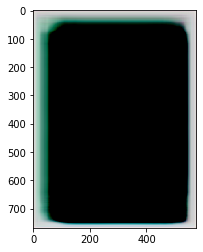

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:200


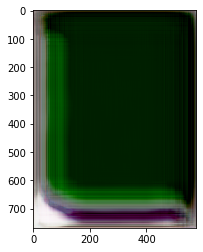

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:300


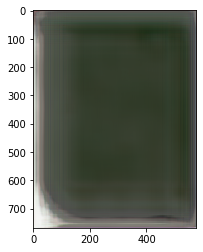

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:400


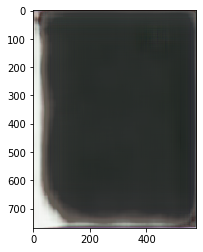

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:500


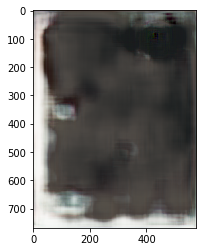

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:600


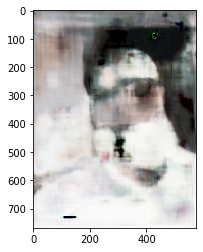

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:700


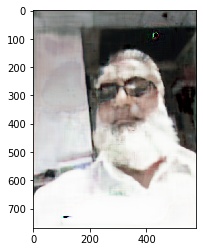

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:800


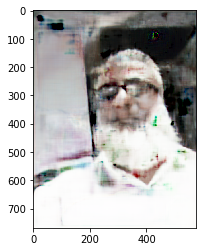

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:900


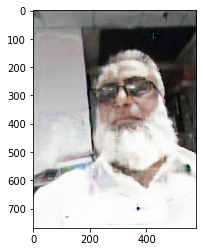

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:1000


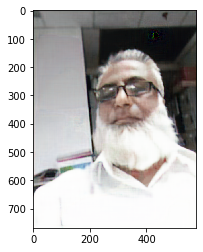

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:1100


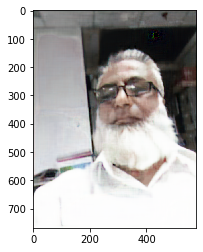

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:1200


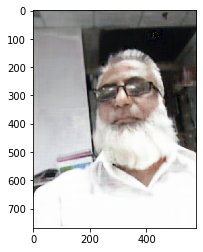

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:1300


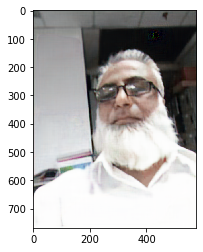

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:1400


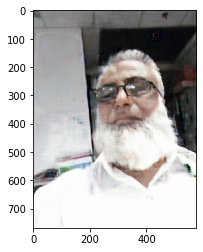

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:1500


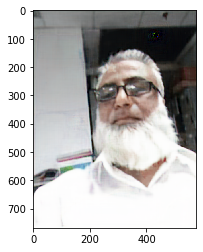

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:1600


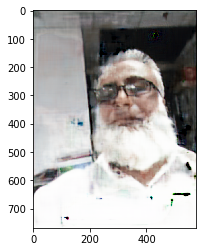

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:1700


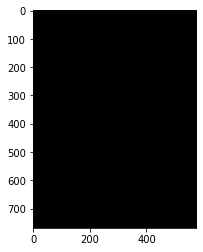

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:1800


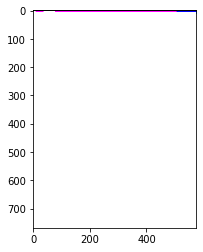

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:1900


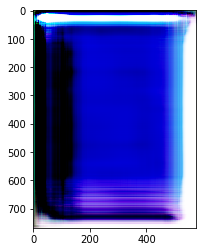

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:2000


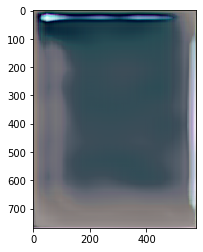

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:2100


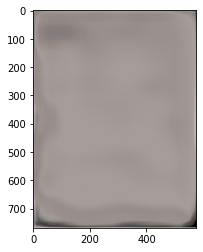

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:2200


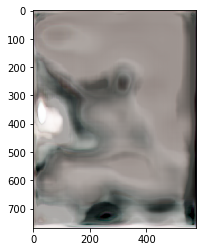

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:2300


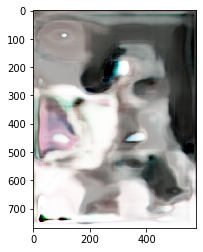

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:2400


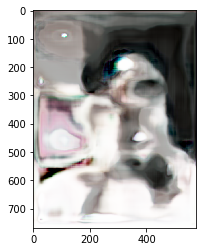

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:2500


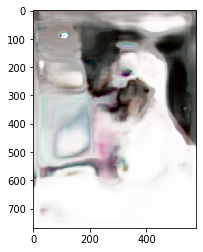

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:2600


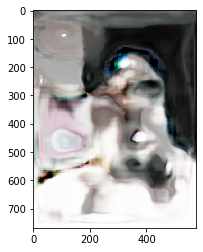

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:2700


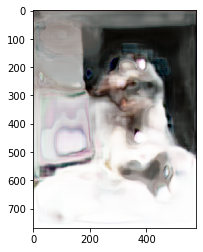

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:2800


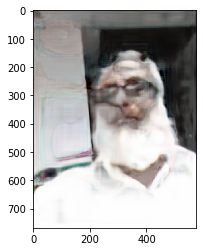

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:2900


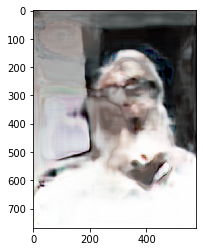

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:3000


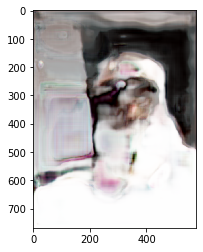

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:3100


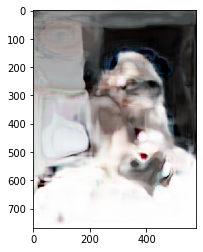

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:3200


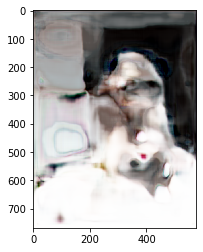

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:3300


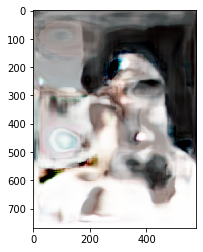

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:3400


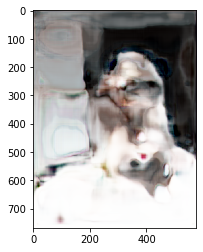

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:3500


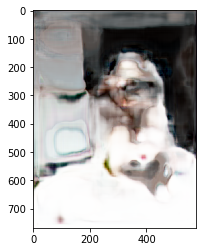

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:3600


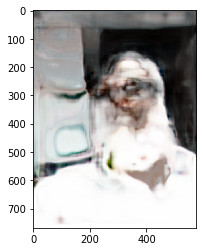

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:3700


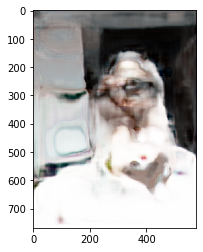

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:3800


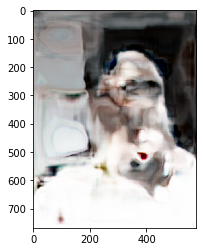

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:3900


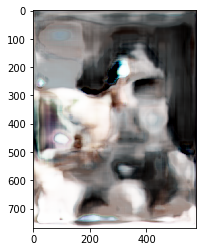

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:4000


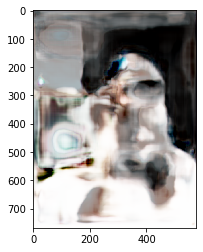

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:4100


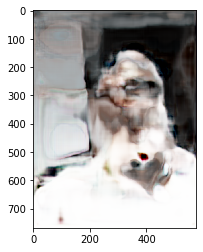

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:4200


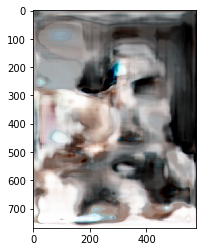

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:4300


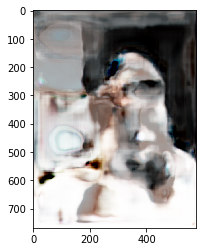

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:4400


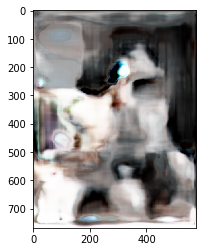

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:4500


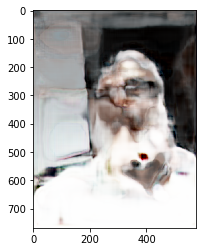

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:4600


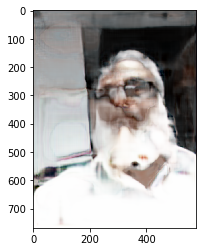

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:4700


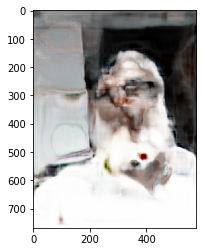

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:4800


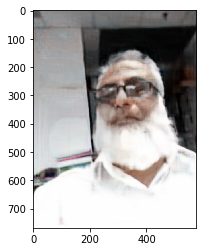

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:4900


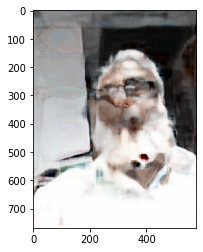

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:5000


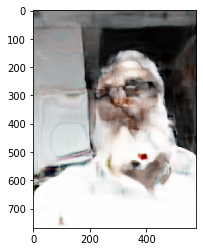

In [21]:
for i in range(50): #Original is 50
    model.fit(**fit_params)
    img_pred = model.predict(net_input, steps=1)
    print('Epoch:' + str((i+1) * n_epochs))
    plt.imshow(img_pred[0])
    plt.show()

In [22]:
!ls

image_thumbnail.jpg  sr_keras.ipynb  wazir.jpg	zebra.bmp


In [23]:
import cv2

out_name = 'keras_zebra.jpg'
# Save the image to disk
cv2.imwrite(out_name, cv2.cvtColor(255 * img_pred[0], cv2.COLOR_RGB2BGR))
#cv2.imwrite(base_dir + out_name, img_pred[0] * 255)

True

In [24]:
out_name = 'keras_zebra.jpg'
# Save the image to disk
cv2.imwrite(out_name, cv2.cvtColor(255 * img_bicubic_np, cv2.COLOR_RGB2BGR))


True

In [25]:
!ls

image_thumbnail.jpg  keras_zebra.jpg  sr_keras.ipynb  wazir.jpg  zebra.bmp


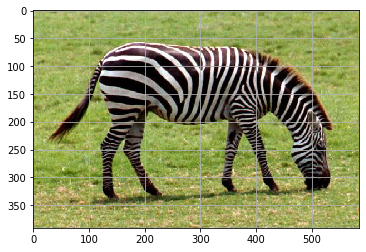

In [26]:
img1 = cv2.imread("zebra.bmp")
img_cvt=cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
plt.imshow(img_cvt)
plt.grid(None)
plt.show()

In [27]:
print(img1.shape)

(391, 586, 3)


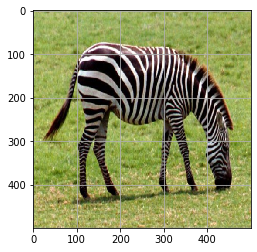

In [28]:
IMG_SIZE = 500
img11 = cv2.resize(img_cvt,(IMG_SIZE,IMG_SIZE))
plt.imshow(img11,cmap="gray")
plt.grid(None)

In [29]:
print(img11.shape)

(500, 500, 3)


In [30]:
INPUT_NAME = "INPUT_LOW_RESOLUTION_IMAGE.bmp"
cv2.imwrite(INPUT_NAME, img11)

True

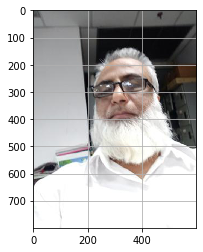

In [31]:
img2 = cv2.imread("keras_zebra.jpg")
img_cvt=cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
plt.imshow(img_cvt)
plt.grid(None)
plt.show()

In [32]:
print(img2.shape)

(800, 600, 3)


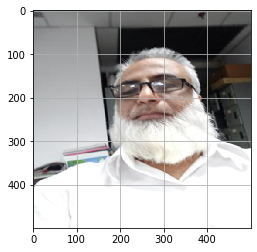

In [33]:
IMG_SIZE = 500
img22 = cv2.resize(img_cvt,(IMG_SIZE,IMG_SIZE))
plt.imshow(img22,cmap="gray")
plt.grid(None)

In [34]:
!ls

image_thumbnail.jpg		keras_zebra.jpg  wazir.jpg
INPUT_LOW_RESOLUTION_IMAGE.bmp	sr_keras.ipynb	 zebra.bmp


In [35]:
from google.colab import files
uploaded = files.upload()

MessageError: ignored

In [0]:
!ls

In [0]:
import numpy 
import math
import cv2
original = cv2.imread("AC1.png")
contrast = cv2.imread("AC.png")
def psnr(img1, img2):
  mse = numpy.mean( (img1 - img2) ** 2 )
  if mse == 0:
    return 100
    PIXEL_MAX = 255.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

d=psnr(original,contrast)
print(d)